In [ ]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed,
                                    MultiHeadAttention, LayerNormalization, Dropout, GlobalAveragePooling1D,
                                    Conv1D)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib
import os
# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
FORECAST_STEPS = 10
TEST_RATIO = 0.2
# Tuning parameters
EPOCHS_LIST = [20]
BATCH_SIZES = [128]
WINDOW_SIZE_SIMULATION = 10  # 6h window
# Transformer parameters for anomaly detection
EMBED_DIM = 128
NUM_HEADS = 4
FF_DIM = 256
DROPOUT_RATE = 0.1
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")
# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../data/cleaned_labeled_dataset.csv'
df = pd.read_csv(file_path, delimiter=',')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

file_path2= '../../data/preprocessed_data.csv'
df_forecast = pd.read_csv(file_path, delimiter=',')
df_forecast['DateTime'] = pd.to_datetime(df_forecast['DateTime'], errors='coerce')
df_forecast.set_index('DateTime', inplace=True)

# Extract labels column if it exists and drop it from the dataset
if 'labels' in df.columns:
    print("✅ Found 'labels' column. Extracting for later evaluation.")
    labels_series = df['labels'].copy()
    df = df.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found. Will assume all samples are normal.")
    labels_series = pd.Series(np.zeros(len(df)))

# Extract labels column if it exists and drop it from the dataset
if 'labels' in df_forecast.columns:
    print("✅ Found 'labels' column. Extracting for later evaluation.")
    labels_df_forecast = df_forecast['labels'].copy()
    df_forecast = df_forecast.drop(columns=['labels'])
else:
    print("⚠️ No 'labels' column found. Will assume all samples are normal.")
    df_forecast = pd.Series(np.zeros(len(df_forecast)))

    
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)
print(f"✅ Scaled dataset shape: {df_scaled.shape}")


# Normalize
scaler = MinMaxScaler()
scaled_data_forecast = scaler.fit_transform(df_forecast.values)
scaled_data_forecast2 = pd.DataFrame(scaled_data_forecast, index=df_forecast.index, columns=df_forecast.columns).astype(np.float32)
print(f"✅ Scaled dataset shape: {scaled_data_forecast2.shape}")


# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
split_idx = int((1 - TEST_RATIO) * len(df_scaled))
train_data_detection = df_scaled.iloc[:split_idx]
train_data = scaled_data_forecast2.iloc[:split_idx]
test_data = scaled_data_forecast2.iloc[split_idx:]
# Split labels in the same way
test_labels = labels_df_forecast.iloc[split_idx:]
print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

In [1]:

# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

# Create sequence labels (a sequence is anomalous if any point in it is anomalous)
def create_sequence_labels(labels, input_steps, forecast_steps):
    """
    Create sequence-level labels from point-level labels.
    A sequence is considered anomalous (1) if any point in its forecast window is anomalous.
    
    Args:
        labels: Array of point-level binary labels (0=normal, >0=anomaly)
        input_steps: Number of input steps (not used for labeling)
        forecast_steps: Number of forecast steps
        
    Returns:
        Array of sequence-level binary labels
    """
    seq_labels = []
    for i in range(len(labels) - input_steps - forecast_steps):
        # If any point in the forecast window is anomalous, mark the sequence as anomalous
        forecast_window_labels = labels[i+input_steps:i+input_steps+forecast_steps]
        # Convert any non-zero value to anomaly (1)
        is_anomalous = np.any(np.array(forecast_window_labels) > 0)
        seq_labels.append(1 if is_anomalous else 0)
    return np.array(seq_labels, dtype=np.int32)

X_train_seq, y_train_seq = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

# Create labels for test sequences - used for anomaly evaluation
test_seq_labels = create_sequence_labels(test_labels.values, INPUT_STEPS, FORECAST_STEPS)
print(f"✅ Training sequences: {X_train_seq.shape}, Testing sequences: {X_test_seq.shape}")
print(f"✅ Test sequence labels shape: {test_seq_labels.shape}, with {np.sum(test_seq_labels)} anomalous sequences")

# ========================
# 6. BUILD LSTM SEQ2SEQ MODEL
# ========================
def build_lstm_seq2seq(input_steps, forecast_steps, input_dim, units=128):
    inputs = Input(shape=(input_steps, input_dim))
    encoded = LSTM(units)(inputs)
    repeated = RepeatVector(forecast_steps)(encoded)
    decoded = LSTM(units, return_sequences=True)(repeated)
    outputs = TimeDistributed(Dense(input_dim))(decoded)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []
for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training LSTM Seq2Seq with epochs={epochs}, batch_size={batch_size}")

        model = build_lstm_seq2seq(INPUT_STEPS, FORECAST_STEPS, X_train_seq.shape[2])
        es = EarlyStopping(patience=5, restore_best_weights=True)
        history = model.fit(X_train_seq, y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)

        val_preds = model.predict(X_test_seq, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test_seq.reshape(-1), val_preds.reshape(-1))
        print(f"✅ Validation RMSE: {val_rmse:.5f}, MAE: {val_mae:.5f}")
        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mae": val_mae
        })
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model
# Save tuning history
history_df = pd.DataFrame(history_records)
history_df.to_csv("lstm_seq2seq_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)
# Save best model
best_model.save("best_lstm_seq2seq_forecaster.keras")
print("\n✅ Best LSTM Seq2Seq model saved.")



✅ GPU is available and will be used.
✅ Found 'labels' column. Extracting for later evaluation.
✅ Found 'labels' column. Extracting for later evaluation.
✅ Scaled dataset shape: (373047, 26)
✅ Scaled dataset shape: (373047, 26)
✅ Training samples: 298437, Testing samples: 74610
✅ Training sequences: (298417, 10, 26), Testing sequences: (74590, 10, 26)
✅ Test sequence labels shape: (74590,), with 33 anomalous sequences

🔵 Training LSTM Seq2Seq with epochs=20, batch_size=128
Epoch 1/20
2099/2099 [==============================] - 80s 28ms/step - loss: 0.0054 - val_loss: 0.0234
Epoch 2/20
2099/2099 [==============================] - 52s 25ms/step - loss: 0.0034 - val_loss: 0.0211
Epoch 3/20
2099/2099 [==============================] - 50s 24ms/step - loss: 0.0030 - val_loss: 0.0205
Epoch 4/20
2099/2099 [==============================] - 54s 26ms/step - loss: 0.0031 - val_loss: 0.0199
Epoch 5/20
2099/2099 [==============================] - 63s 30ms/step - loss: 0.0032 - val_loss: 0.0194
Epo

In [2]:
# ========================
# 8. BUILD AND TRAIN TRANSFORMER AUTOENCODER FOR ANOMALY DETECTION
# ========================
def create_ae_sequences(data, seq_len):
    return np.array([data[i:i+seq_len] for i in range(len(data) - seq_len)], dtype=np.float32)

X_ae_train = create_ae_sequences(train_data_detection.values, FORECAST_STEPS)

def transformer_encoder(inputs, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
    # Multi-head self-attention
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim)(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(embed_dim)(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    
    # Add & Norm
    return LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)

def build_transformer_autoencoder(input_steps, input_dim, embed_dim=128, num_heads=4, ff_dim=256, dropout_rate=0.1):
    inputs = Input(shape=(input_steps, input_dim))
    
    # Initial projection to embed_dim
    x = Conv1D(filters=embed_dim, kernel_size=1, activation='relu')(inputs)
    
    # Encoder: Transformer blocks
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)
    
    # Bottleneck
    encoded = GlobalAveragePooling1D()(x)
    
    # Decoder: Expand to sequence
    x = RepeatVector(input_steps)(encoded)
    
    # Decoder: Transformer blocks
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)
    x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout_rate)
    
    # Output projection back to original dimensions
    outputs = TimeDistributed(Dense(input_dim))(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build and train the transformer autoencoder for anomaly detection
transformer_ae = build_transformer_autoencoder(
    FORECAST_STEPS, 
    X_ae_train.shape[2],
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    dropout_rate=DROPOUT_RATE
)

# Train Transformer AE
es = EarlyStopping(patience=5, restore_best_weights=True)
transformer_ae.fit(
    X_ae_train, 
    X_ae_train, 
    validation_split=0.1, 
    epochs=7, 
    batch_size=128, 
    callbacks=[es], 
    verbose=1
)

#transformer_ae.save("best_transformer_autoencoder.h5")
print("\n✅ Transformer Autoencoder trained and saved.")

Epoch 1/7
2099/2099 [==============================] - 170s 75ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 2/7
2099/2099 [==============================] - 160s 76ms/step - loss: 7.6573e-04 - val_loss: 0.0022
Epoch 3/7
2099/2099 [==============================] - 157s 75ms/step - loss: 6.1095e-04 - val_loss: 0.0020
Epoch 4/7
2099/2099 [==============================] - 158s 75ms/step - loss: 5.5120e-04 - val_loss: 0.0018
Epoch 5/7
2099/2099 [==============================] - 155s 74ms/step - loss: 0.0017 - val_loss: 0.0081
Epoch 6/7
2099/2099 [==============================] - 160s 76ms/step - loss: 6.0683e-04 - val_loss: 0.0027
Epoch 7/7
2099/2099 [==============================] - 156s 74ms/step - loss: 5.0790e-04 - val_loss: 0.0022

✅ Transformer Autoencoder trained and saved.


In [14]:
# Use the last 3000 points of the test data for simulation
test_data_tail = test_data.tail(70000).reset_index(drop=True)
test_labels_tail = test_labels.tail(70000).reset_index(drop=True)

# ========================
# 9. REAL-TIME SIMULATION WITH MANUAL THRESHOLD CONTROL
# ========================
simulation_X, simulation_y = create_sequences(test_data_tail.values, INPUT_STEPS, FORECAST_STEPS)
# Create corresponding labels for evaluation
simulation_labels = create_sequence_labels(test_labels_tail.values, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
reconstruction_list = []
reconstruction_errors = []
true_windows = []

# Process all samples without overlapping
step_size = WINDOW_SIZE_SIMULATION  # Use the window size as step size to avoid overlap
for i in range(0, len(simulation_X), step_size):
    # Get the current window batch (up to step_size samples)
    window_X = simulation_X[i:i+step_size]
    window_y_true = simulation_y[i:i+step_size]
    
    if len(window_X) == 0:
        continue
    
    # Use LSTM Seq2Seq for forecasting
    y_pred_future = best_model.predict(window_X, batch_size=128, verbose=1)
    X_forecast = y_pred_future  # No need to expand dims as we're processing batches
    
    # Use Transformer Autoencoder for anomaly detection
    y_reconstructed = transformer_ae.predict(X_forecast, batch_size=128, verbose=1)
    
    # Calculate reconstruction error for each sample in the batch
    batch_reconstruction_errors = np.mean((y_pred_future - y_reconstructed)**2, axis=(1, 2))
    
    # Store predictions and errors
    forecast_list.append(y_pred_future)
    reconstruction_list.append(y_reconstructed)
    reconstruction_errors.append(batch_reconstruction_errors)
    true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")

1/1 [==============================] - 0s 118ms/step

✅ Real-time simulation complete.



✅ Using 70th percentile threshold: 0.00041

Anomaly detection summary:
Number of true anomalies: 33
Numberof detected anomalies: 20994

📈 Anomaly Detection Evaluation:
Precision: 0.00029
Recall:    0.18182
F1 Score:  0.00057


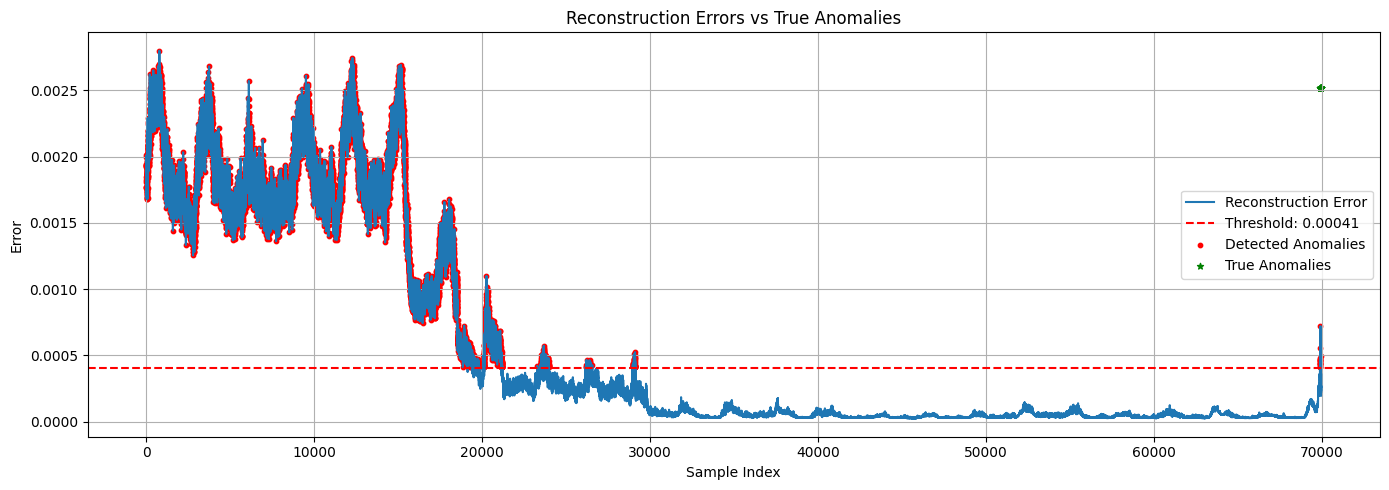


✅ Analysis complete.

To change the threshold:
1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold
2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: 70th)
3. Re-run the script to see results with the new threshold


In [18]:
MANUAL_THRESHOLD=None
MANUAL_PERCENTILE=70
# Flatten the reconstruction errors list for threshold calculation
all_reconstruction_errors = np.concatenate(reconstruction_errors)

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(simulation_labels), len(all_reconstruction_errors))
true_labels_subset = simulation_labels[:min_length]
errors_subset = all_reconstruction_errors[:min_length]

# Determine threshold to use
if MANUAL_THRESHOLD is not None:
    # Use manually specified threshold
    threshold = MANUAL_THRESHOLD
    print(f"\n✅ Using manually specified threshold: {threshold:.5f}")
else:
    # Use percentile-based threshold
    threshold = np.percentile(all_reconstruction_errors, MANUAL_PERCENTILE)
    print(f"\n✅ Using {MANUAL_PERCENTILE}th percentile threshold: {threshold:.5f}")

# Apply threshold to get anomaly flags
anomaly_flags_list = [errors > threshold for errors in reconstruction_errors]
all_detected = np.concatenate([flags for flags in anomaly_flags_list])

# Make sure we're only considering windows where we have both predictions and labels
min_length = min(len(true_labels_subset), len(all_detected))
true_labels_subset = true_labels_subset[:min_length]
all_detected_subset = all_detected[:min_length]

# Print summary of anomalies
print(f"\nAnomaly detection summary:")
print(f"Number of true anomalies: {np.sum(true_labels_subset)}")
print(f"Numberof detected anomalies: {np.sum(all_detected_subset)}")

# Compute metrics
precision = precision_score(true_labels_subset, all_detected_subset, zero_division=0)
recall = recall_score(true_labels_subset, all_detected_subset, zero_division=0)
f1 = f1_score(true_labels_subset, all_detected_subset, zero_division=0)

print(f"\n📈 Anomaly Detection Evaluation:")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1 Score:  {f1:.5f}")

# ========================
# 10. PLOT RESULTS
# ========================
# Plot Reconstruction Errors with True Labels
plt.figure(figsize=(14,5))

# Ensure we're only plotting up to the minimum length we have data for
min_plot_len = min(len(all_reconstruction_errors), len(true_labels_subset))
plot_errors = all_reconstruction_errors[:min_plot_len]
plot_labels = true_labels_subset[:min_plot_len]
plot_detected = all_detected_subset[:min_plot_len]

plt.plot(plot_errors, label='Reconstruction Error')
plt.axhline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')

# Detected anomalies
detected_indices = np.where(plot_detected == 1)[0]
plt.scatter(detected_indices,
            plot_errors[detected_indices],
            color='red', label='Detected Anomalies', s=10)

# True anomalies
true_anomaly_indices = np.where(plot_labels == 1)[0]
if len(true_anomaly_indices) > 0:
    plt.scatter(true_anomaly_indices,
                np.ones_like(true_anomaly_indices) * np.max(plot_errors)*0.9,
                color='green', marker='*', label='True Anomalies', s=20)
else:
    print("No true anomalies found in the subset of data being visualized")

plt.title("Reconstruction Errors vs True Anomalies")
plt.xlabel("Sample Index")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("reconstruction_errors_with_threshold.png")
plt.show()

print("\n✅ Analysis complete.")
print("\nTo change the threshold:")
print("1. Set MANUAL_THRESHOLD to a specific value to use that exact threshold")
print("2. Set MANUAL_PERCENTILE to use a percentile-based threshold (current: {}th)".format(MANUAL_PERCENTILE))
print("3. Re-run the script to see results with the new threshold")